# Wetter
* Schaumann Diss
* Vergleich Algorithmus aus Doktorarbeit von Schaumann mit allg. hill climbing
* Mangels echter Daten: Vergleich anhand von unrealistischen Zufallsdaten
* Mangels echter loss-Funktion: Varianz

conda weather

## Datengenerierung, loss

In [30]:
import numpy as np
import time
import random
import matplotlib.pyplot as plt

def rnd_data(num_tiles,tile_size=(9,9)):
    return np.random.random(size=(num_tiles,*tile_size))

def rnd_data2(num_tiles,tile_size=(9,9)):
    return np.random.random(size=(num_tiles,*tile_size))*np.random.randint(low=1,high=11,size=(tile_size))

def variance_loss(tile):
    return np.var(tile)

rt_off=True
def running_time(fun):
    def decorated(*args,**kwargs):
        start=time.time()
        res=fun(*args,**kwargs)
        if not rt_off:
            print("running time: {:.1f}s".format(time.time()-start))
        return res
    return decorated

# rudimentäre Funktion, um loss zu vergleichen
def loss_compare(before,after,loss):
    before_losses=[loss(tile) for tile in before]
    after_losses=[loss(tile) for tile in after]
    head="tile #: "
    b_str,a_str="before: ","after : "
    no=1
    for bl,al in zip(before_losses,after_losses):
        head+="{:^6}  ".format(no)
        b_str+="{:6.3f}  ".format(bl)
        a_str+="{:6.3f}  ".format(al)
        no+=1
    b_str+="{:7.3f}".format(sum(before_losses))
    a_str+="{:7.3f}".format(sum(after_losses))
    head+="total"
    print(head)
    print(b_str)
    print(a_str)

loss_fun=variance_loss

tiles=rnd_data2(2,tile_size=(3,3))
tiles

array([[[1.35077479, 7.42724036, 2.05913113],
        [8.17149082, 1.5238735 , 1.07282766],
        [2.22315564, 3.271547  , 0.74892193]],

       [[0.27849457, 7.19669373, 0.80146106],
        [4.36381785, 0.91776288, 6.08587939],
        [5.71752404, 0.89704853, 0.33207494]]])

## Schaumann hill climbing
Meine Interpretation des Pseudocodes der Doktorarbeit

In [2]:
def schaumann_single_step(j,tiles,loss):
    N=len(tiles)
    xlen,ylen=tiles.shape[1],tiles.shape[2]
    tile_coords=[(x,y) for x in range(xlen) for y in range(ylen)]
    improvement=True
    best_loss=loss(tiles[j])
    while improvement:
        improvement=False
        for px,py in np.random.permutation(tile_coords):
            best_k=j
            for k in range(j+1,N):
                tiles[j,px,py],tiles[k,px,py]=tiles[k,px,py],tiles[j,px,py]
                swap_loss=loss(tiles[j])
                if swap_loss<best_loss:
                    best_loss=swap_loss
                    best_k=k
                    improvement=True
                tiles[j,px,py],tiles[k,px,py]=tiles[k,px,py],tiles[j,px,py]
            if improvement:
                tiles[j,px,py],tiles[best_k,px,py]=tiles[best_k,px,py],tiles[j,px,py]
    return tiles

@running_time
def schaumann_hill_climbing(tiles,loss):
    tiles=tiles.copy()
    N=len(tiles)
    for j in range(N-1):
        schaumann_single_step(j,tiles,loss)
    return tiles

In [3]:
tiles=rnd_data2(20)
new_tiles=schaumann_hill_climbing(tiles,loss_fun)
loss_compare(tiles,new_tiles,loss_fun)

running time: 0.0s


array([[[3.91807901, 1.06044387, 1.97196101],
        [1.51839908, 2.84018194, 1.15914635],
        [0.89705756, 0.56270873, 1.2244841 ]],

       [[5.82314102, 0.13022814, 2.73735594],
        [6.02173234, 4.06900209, 5.3792241 ],
        [0.5619366 , 0.01466429, 2.9964117 ]]])

## hill climbing 

Erster Versuch
* zufälliger Austausch zwischen zwei tiles bis die Zeit abläuft

In [6]:
def perform_random_swap(tiles,loss):
    N,lenx,leny=tiles.shape[0],tiles.shape[1],tiles.shape[2]
    j,k=random.sample(range(N),2)
    px,py=random.randrange(lenx),random.randrange(leny)
    before_loss_j=loss(tiles[j])
    before_loss_k=loss(tiles[k])
    tiles[j,px,py],tiles[k,px,py]=tiles[k,px,py],tiles[j,px,py]
    loss_j,loss_k=loss(tiles[j]),loss(tiles[k])
    if before_loss_j+before_loss_k<=loss_j+loss_k:
        # undo
        tiles[j,px,py],tiles[k,px,py]=tiles[k,px,py],tiles[j,px,py]
        
@running_time
def hill_climbing(tiles,loss,time_budget):
    start=time.time()
    tiles=tiles.copy()
    while(time.time()-start<time_budget):
        perform_random_swap(tiles,loss)
    return tiles
        

Zweiter Versuch
* wie erster, nur: berechnen losses nicht immer neu

In [8]:
def perform_random_swap2(tiles,loss_fun,losses):
    N,lenx,leny=tiles.shape[0],tiles.shape[1],tiles.shape[2]
    j,k=random.sample(range(N),2)
    px,py=random.randrange(lenx),random.randrange(leny)
    tiles[j,px,py],tiles[k,px,py]=tiles[k,px,py],tiles[j,px,py]
    loss_j,loss_k=loss_fun(tiles[j]),loss_fun(tiles[k])
    if losses[j]+losses[k]<=loss_j+loss_k:
        # undo
        tiles[j,px,py],tiles[k,px,py]=tiles[k,px,py],tiles[j,px,py]
    else:
        losses[j]=loss_j
        losses[k]=loss_k
        
@running_time
def hill_climbing2(tiles,loss,time_budget):
    start=time.time()
    tiles=tiles.copy()
    losses=[loss(tile) for tile in tiles]
    while(time.time()-start<time_budget):
        perform_random_swap2(tiles,loss,losses)
    return tiles
        

Dritter Versuch:
* tiles mit hohem loss werden bevorzugt für einen Tausch herangezogen

In [10]:
def loss_weighted_Bernoulli(losses):
    total=sum(losses)
    cum=0
    p=random.random()*total
    for j in range(len(losses)):
        cum+=losses[j]
        if p<=cum:
            return j
    return j

def perform_random_swap3(tiles,loss_fun,losses):
    N,lenx,leny=tiles.shape[0],tiles.shape[1],tiles.shape[2]
    j=loss_weighted_Bernoulli(losses)
    k=random.randrange(N) 
    if j==k:
        return # try again
    px,py=random.randrange(lenx),random.randrange(leny)
    tiles[j,px,py],tiles[k,px,py]=tiles[k,px,py],tiles[j,px,py]
    loss_j,loss_k=loss_fun(tiles[j]),loss_fun(tiles[k])
    if losses[j]+losses[k]<=loss_j+loss_k:
        # undo
        tiles[j,px,py],tiles[k,px,py]=tiles[k,px,py],tiles[j,px,py]
    else:
        losses[j]=loss_j
        losses[k]=loss_k
        
@running_time
def hill_climbing3(tiles,loss,time_budget):
    start=time.time()
    tiles=tiles.copy()
    losses=[loss(tile) for tile in tiles]
    while(time.time()-start<time_budget):
        perform_random_swap3(tiles,loss,losses)
    return tiles
  

## Vergleich der Algorithmen

In [31]:
def run_repeatedly(algo,loss_fun,tile_data):
    times=[]
    results=[]
    for tiles in tile_data:
        start=time.time()
        results.append(algo(tiles,loss_fun))
        times.append(time.time()-start)
    return times,results

def show_res(losses,times,algo_name):
    fig,ax=plt.subplots(figsize=(6,3))
    ax.boxplot(losses)
    ax.set_title(algo_name)
    ax.set_xlabel("tile number")
    ax.set_ylabel("loss")
    avg_time=np.mean(times)
    avg_loss=np.mean(losses)
    print("avg running time: {:.1f}s".format(avg_time))
    print("avg loss: {:.2f}".format(avg_loss))

def run_and_show(algo,loss_fun,tile_data,algo_name):
    times,res=run_repeatedly(algo,loss_fun,tile_data)
    losses=np.array([[loss_fun(tile) for tile in tiles] for tiles in res])
    show_res(losses,times,algo_name)
    
repeats=10
data_gen=rnd_data2
num_tiles=20
tile_data=[data_gen(num_tiles) for _ in range(repeats)]

avg running time: 0.0s
avg loss: 5.36


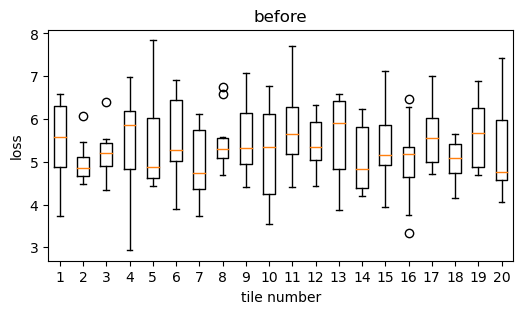

In [34]:
pre_losses=np.array([[loss_fun(tile) for tile in tiles] for tiles in tile_data])
show_res(pre_losses,[0],"before")

running time: 2.9s
running time: 2.9s
running time: 2.2s
running time: 2.8s
running time: 2.4s
running time: 3.0s
running time: 2.7s
running time: 3.2s
running time: 2.2s
running time: 2.4s
avg running time: 2.7s
avg loss: 4.65


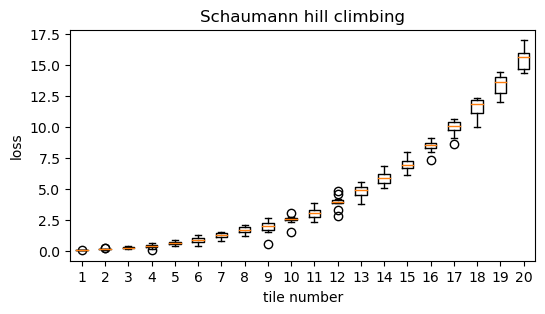

In [32]:
run_and_show(schaumann_hill_climbing,loss_fun,tile_data,"Schaumann hill climbing")

Wie erwartet: loss ist zu Beginn spektakulär gut, dann immer schlechter

running time: 4.0s
running time: 4.0s
running time: 4.0s
running time: 4.0s
running time: 4.0s
running time: 4.0s
running time: 4.0s
running time: 4.0s
running time: 4.0s
running time: 4.0s
avg running time: 4.0s
avg loss: 3.22


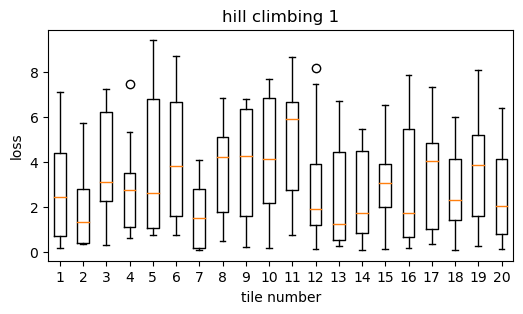

In [35]:
time_budget=4
run_and_show(lambda t,l: hill_climbing(t,l,time_budget),loss_fun,tile_data,"hill climbing 1")

In [ ]:
run_and_show(lambda t,l: hill_climbing2(t,l,time_budget),loss_fun,tile_data,"hill climbing 2")

running time: 4.0s


In [ ]:
run_and_show(lambda t,l: hill_climbing3(t,l,time_budget),loss_fun,tile_data,"hill climbing 3")

## Vergleich anhand strukturierter Daten

* wir nutzen [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) als strukturierte Daten
* das sind zwar Bilddaten (32x32 RGB), sind aber von der Struktur her sicher Wetterdaten ähnlicher als gleichverteilte Zufallsdaten
* wir laden den Datensatz herunter und machen Schwarz-Weiß-Bilder draus 

In [40]:
!wget -q --show-progress https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz

cifar-10-python.tar 100%[===================>] 162,60M  6,85MB/s    in 28s     


In [80]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

data_dict=unpickle("cifar-10-batches-py/data_batch_1")

def to_grayscale(img):
    return 1-(0.299*img[:,:,0]+0.587*img[:,:,1]+0.114*img[:,:,2])

def process(data_dict):
    imgs=[]
    raw_imgs=img_dict[b'data']
    for raw_img in raw_imgs:
        img=np.moveaxis(raw_img.reshape(3,32,32),0,-1) / 255
        img=to_grayscale(img)
        imgs.append(img)
    return np.array(imgs)

imgs=process(data_dict)

Gucken wir uns ein paar Beispielbilder an.

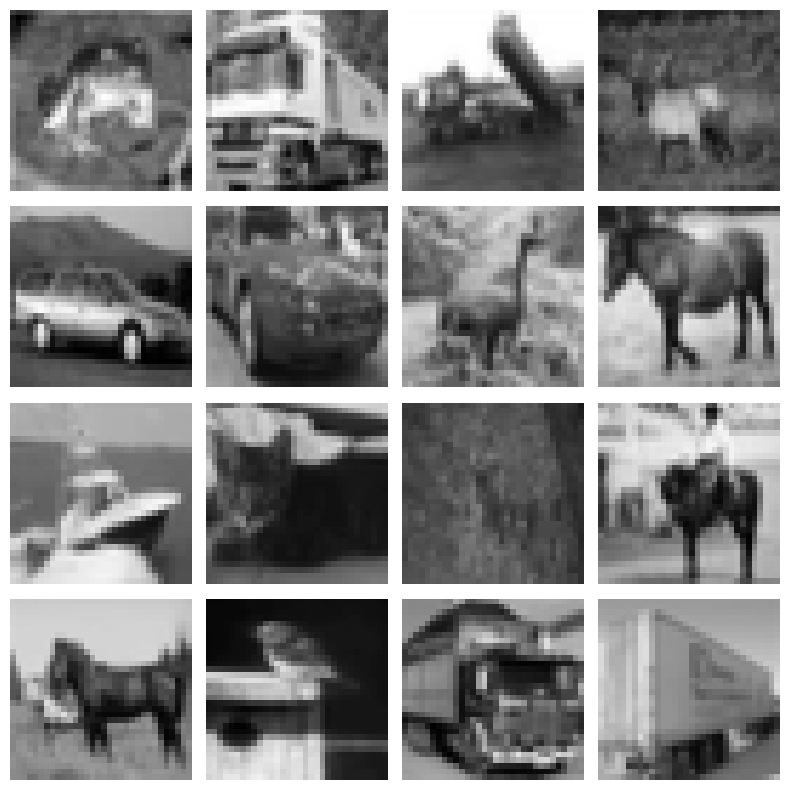

In [117]:
def show_pics(imgs):
    fig,axs=plt.subplots(4,4,figsize=(8,8))
    axs=axs.flat
    for ax,img in zip(axs,imgs):
        ax.imshow(img,cmap='binary',vmin=0,vmax=1)
        ax.axis('off')
    plt.tight_layout()
show_pics(imgs)

als nächstes: permutiere jedes Pixel zufällig zwischen den 16 Bildern innerhalb eines Satzes (hier die 16 Bilder, die in der vorherigen Zelle angezeigt wurden). Wie zu erwarten: Schneegestöber.

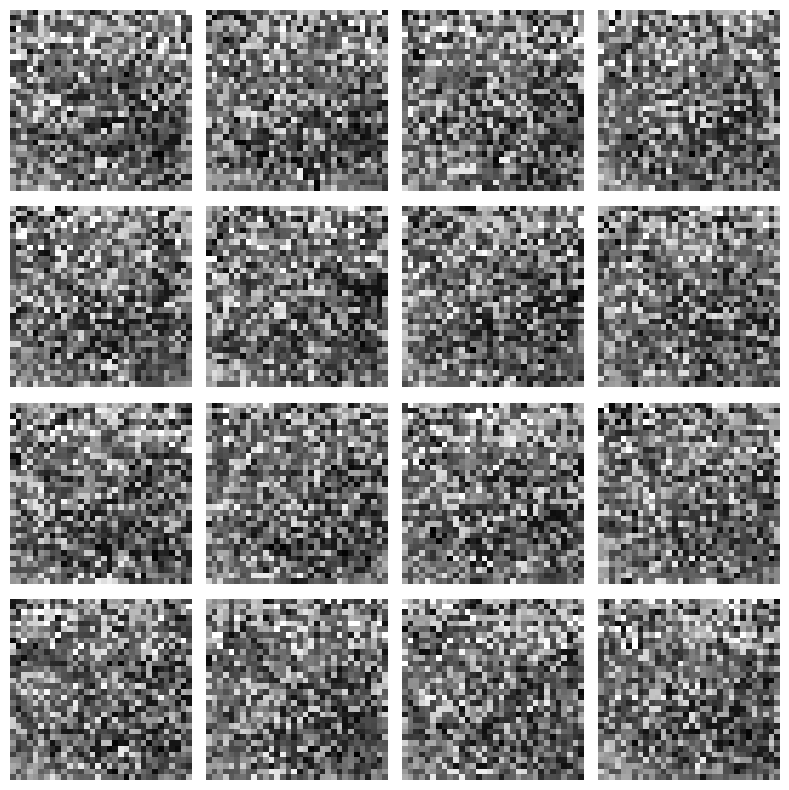

In [118]:
def scramble(imgs):
    scrambled_imgs=np.zeros(imgs.shape) 
    for i in range(imgs.shape[1]):
        for j in range(imgs.shape[2]):
            scrambled_imgs[:,i,j]=np.random.permutation(imgs[:,i,j])
    return scrambled_imgs

scrambled_imgs=scramble(imgs[:16])
show_pics(scrambled_imgs)

Wir wenden die Algorithmen an.

running time: 59.9s


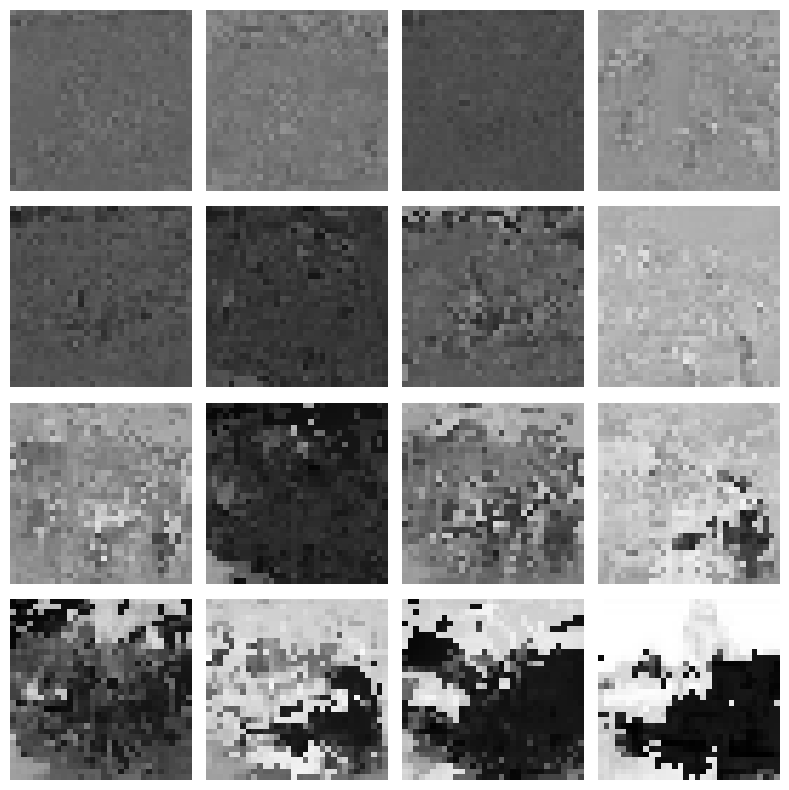

In [119]:
new_tiles=schaumann_hill_climbing(scrambled_imgs,loss_fun)
show_pics(new_tiles)

Interessant hier: die Extreme landen im letzten Bild. Wird das weggeschmissen, entsteht schon eine deutliche Verzerrung.

In [120]:
loss_compare(scrambled_imgs,new_tiles,loss_fun)

tile #:   1       2       3       4       5       6       7       8       9       10      11      12      13      14      15      16    total
before:  0.058   0.056   0.059   0.054   0.058   0.059   0.055   0.052   0.060   0.053   0.059   0.053   0.056   0.055   0.058   0.055    0.901
after :  0.001   0.001   0.000   0.002   0.002   0.002   0.006   0.002   0.009   0.009   0.022   0.027   0.043   0.076   0.120   0.183    0.503


running time: 60.0s


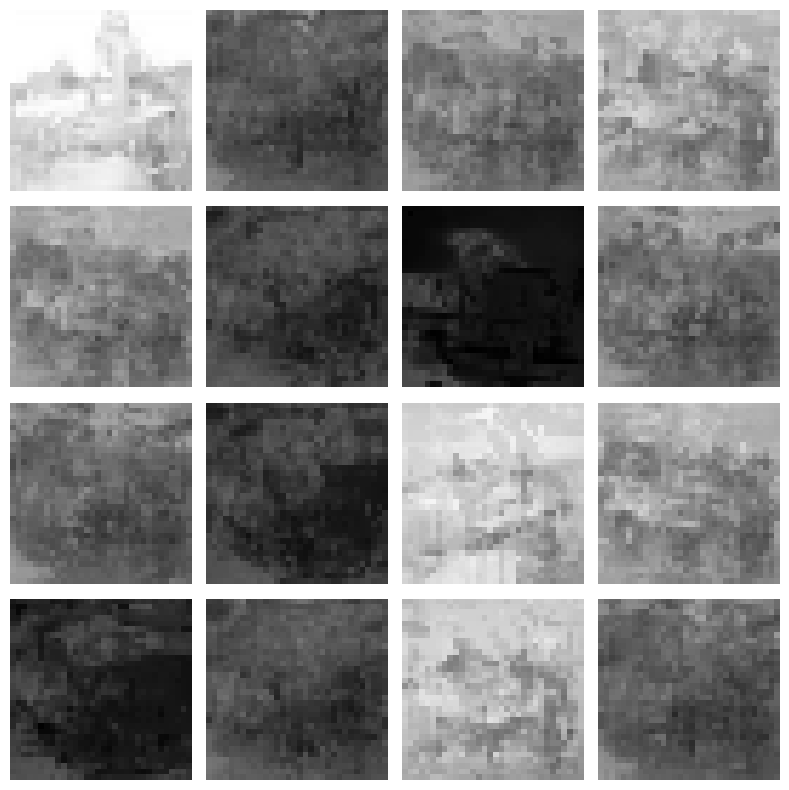

In [121]:
new_tiles2=hill_climbing2(scrambled_imgs,loss_fun,time_budget=60)
show_pics(new_tiles2)

In [122]:
loss_compare(scrambled_imgs,new_tiles2,loss_fun)

tile #:   1       2       3       4       5       6       7       8       9       10      11      12      13      14      15      16    total
before:  0.058   0.056   0.059   0.054   0.058   0.059   0.055   0.052   0.060   0.053   0.059   0.053   0.056   0.055   0.058   0.055    0.901
after :  0.011   0.005   0.011   0.011   0.011   0.005   0.004   0.010   0.008   0.006   0.010   0.011   0.005   0.005   0.012   0.006    0.132


running time: 60.0s


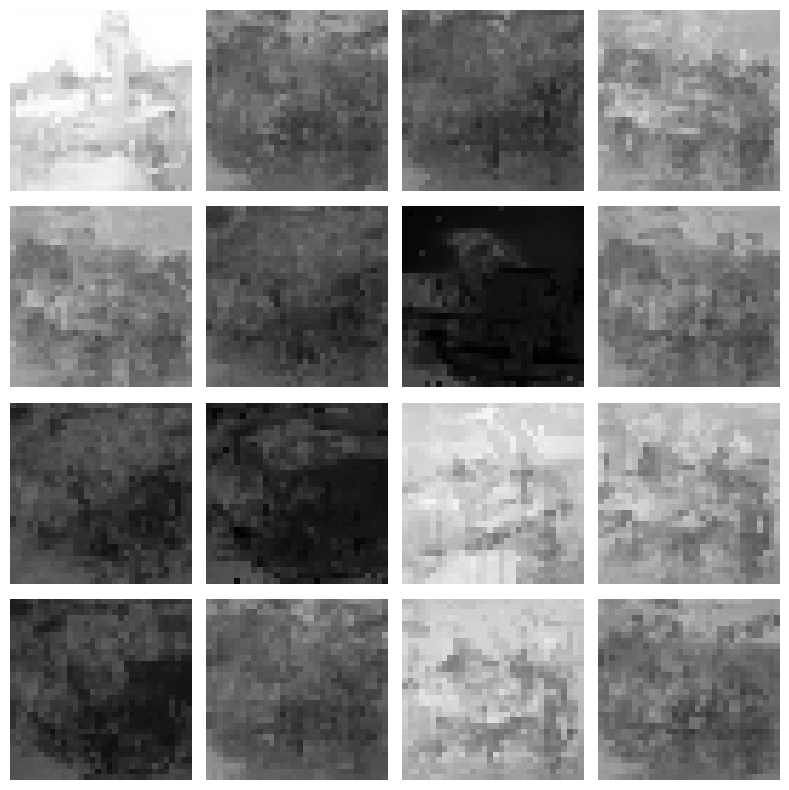

In [123]:
new_tiles3=hill_climbing3(scrambled_imgs,loss_fun,time_budget=60)
show_pics(new_tiles3)

In [124]:
loss_compare(scrambled_imgs,new_tiles3,loss_fun)

tile #:   1       2       3       4       5       6       7       8       9       10      11      12      13      14      15      16    total
before:  0.058   0.056   0.059   0.054   0.058   0.059   0.055   0.052   0.060   0.053   0.059   0.053   0.056   0.055   0.058   0.055    0.901
after :  0.011   0.008   0.005   0.011   0.011   0.005   0.004   0.011   0.005   0.005   0.010   0.011   0.006   0.006   0.012   0.010    0.132


Rein vom Augenschein her sehen die beiden letzteren Ergebnisse besser aus. Wir machen das ganze noch einmal systematisch. Damit es schneller geht, schneiden wir aus den Bildern 16x16-Viertel heraus. Diese Viertel fassen wir zu Sätzen von 20 Viertel zusammen und wiederholen dann 10mal.

In [113]:
batch_size=20
repeats=10
imgs16x16=imgs[:batch_size*repeats,:16,:16].reshape(repeats,batch_size,16,16)
tile_data=np.array([scramble(batch) for batch in imgs16x16])
tile_data.shape

(10, 20, 16, 16)

running time: 18.0s
running time: 16.6s
running time: 16.1s
running time: 20.9s
running time: 17.9s
running time: 13.9s
running time: 12.4s
running time: 14.2s
running time: 17.1s
running time: 17.4s
avg running time: 16.4s
avg loss: 0.02


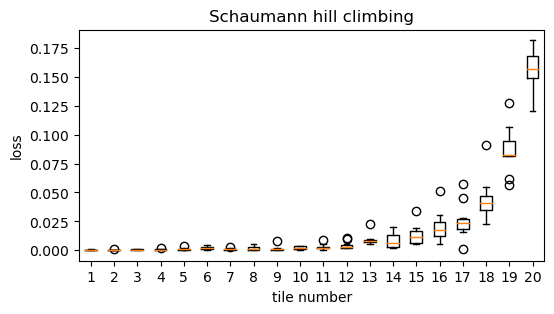

In [114]:
run_and_show(schaumann_hill_climbing,loss_fun,tile_data,"Schaumann hill climbing")

running time: 17.0s
running time: 17.0s
running time: 17.0s
running time: 17.0s
running time: 17.0s
running time: 17.0s
running time: 17.0s
running time: 17.0s
running time: 17.0s
running time: 17.0s
avg running time: 17.0s
avg loss: 0.00


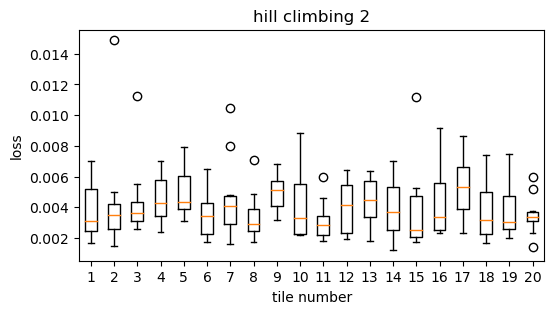

In [115]:
time_budget=17
run_and_show(lambda t,l: hill_climbing2(t,l,time_budget),loss_fun,tile_data,"hill climbing 2")

running time: 17.0s
running time: 17.0s
running time: 17.0s
running time: 17.0s
running time: 17.0s
running time: 17.0s
running time: 17.0s
running time: 17.0s
running time: 17.0s
running time: 17.0s
avg running time: 17.0s
avg loss: 0.00


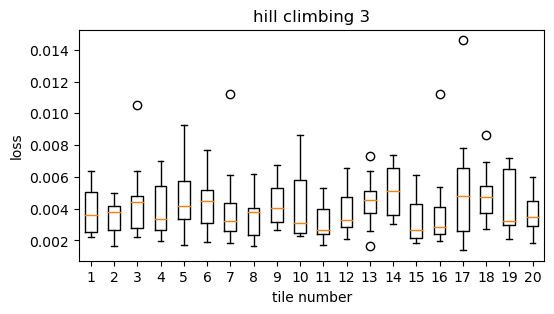

In [116]:
run_and_show(lambda t,l: hill_climbing3(t,l,time_budget),loss_fun,tile_data,"hill climbing 3")

Das Ergebnis ist ähnlich wie bei den reinen Zufallsdaten.

Weitere Verbesserungsmöglichkeiten:
* das hier ist reines hill climbing (es wird immer verbessert); lokale Suche, die auch mal eine Verschlechterung akzeptiert ist sicher noch besser
* Start mit greedy-Lösung? Dh, sortiere für jeden Pixel nach Intensität und setze so die Einzelbilder zusammen. Danach: lokale Suche. (Hier geht die Annahme ein, dass die eigentliche Wetter-loss-Funktion ebenfalls eher homogene Bilder bevorzugt.)
* swaps von Pixelblöcken

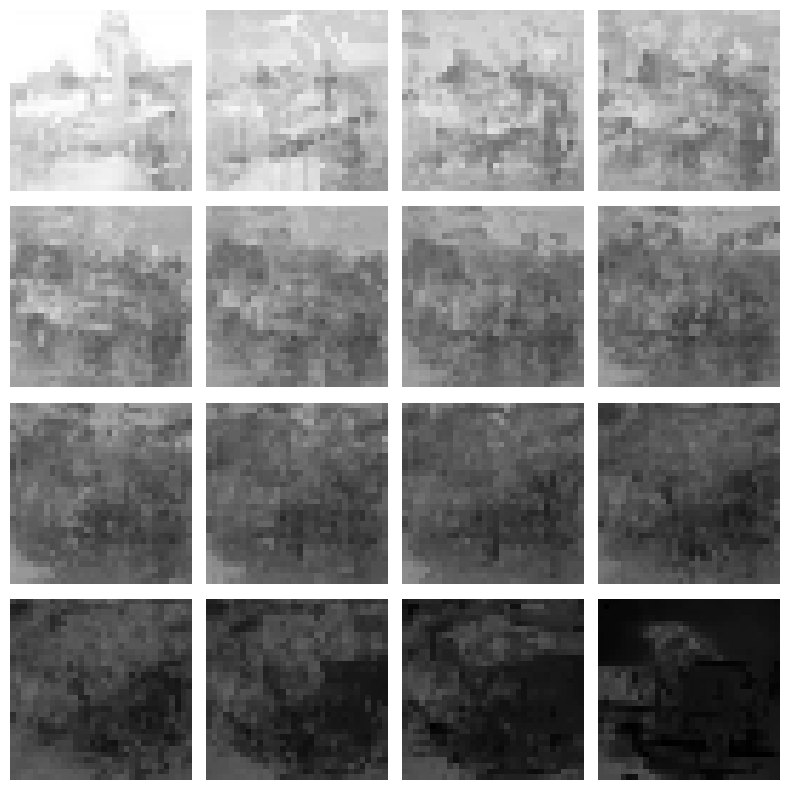

In [125]:
def greedy(tiles):
    new_tiles=np.zeros(tiles.shape) 
    for i in range(tiles.shape[1]):
        for j in range(tiles.shape[2]):
            new_tiles[:,i,j]=tiles[np.argsort(tiles[:,i,j]),i,j]
    return new_tiles

tiles_greedy=greedy(scrambled_imgs)
show_pics(tiles_greedy)    

In [126]:
loss_compare(scrambled_imgs,tiles_greedy,loss_fun)

tile #:   1       2       3       4       5       6       7       8       9       10      11      12      13      14      15      16    total
before:  0.058   0.056   0.059   0.054   0.058   0.059   0.055   0.052   0.060   0.053   0.059   0.053   0.056   0.055   0.058   0.055    0.901
after :  0.011   0.010   0.011   0.011   0.011   0.011   0.011   0.010   0.008   0.006   0.005   0.005   0.005   0.006   0.005   0.004    0.132
